In [2]:
from json import load
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from elyawy.io import load_sims_df
from elyawy.constants import SUMSTATS_LIST

In [3]:

res_path = Path("/home/elyawy/Desktop/ENSG00000002933_TMEM176A/") # os.path.join(all_outputs_path, dir_name)

full_data, regressors, reg_stats = load_sims_df(data_path=res_path, correction=True)

In [4]:
full_zipf = shuffle(full_data[full_data["length_distribution"] == "zipf"])
full_geometric = shuffle(full_data[full_data["length_distribution"] == "geometric"])
full_poisson = shuffle(full_data[full_data["length_distribution"] == "poisson"])

In [5]:
num_test = 100
test_zipf = full_zipf[:num_test]
test_geometric = full_geometric[:num_test]
test_poisson = full_poisson[:num_test]

test_data = shuffle(pd.concat([test_zipf, test_geometric, test_poisson]))
remaining_data = shuffle(pd.concat([full_zipf[num_test:],full_geometric[num_test:], full_poisson[num_test:]]))

In [6]:
test_data_sum_stats = test_data[SUMSTATS_LIST].astype("float")
remaining_sum_stats = remaining_data[SUMSTATS_LIST].astype("float")
sum_stat_cov = remaining_sum_stats.cov().values
inv_covmat = np.linalg.inv(sum_stat_cov)

In [7]:
predicted_dist = remaining_data["length_distribution"].reset_index(drop=True)
true_dists = test_data["length_distribution"].reset_index(drop=True)

In [8]:
abc_counts = []
epsilon = 100
count = 0
for u in test_data_sum_stats.values:
    def mahalanobis(simulated_stats):
        u_minus_v = simulated_stats-u
        left = np.dot(u_minus_v, inv_covmat)
        mahal = np.sqrt(np.sum(u_minus_v*left, axis=1))
        return mahal
    distances_from_u = mahalanobis(remaining_sum_stats).reset_index(drop=True)
    distances_from_u.name = "distances"
    distances_from_u = pd.concat([distances_from_u, predicted_dist], axis=1)
    distances_from_u.columns = ["distances", "predicted_distribution"]

    dist_distribution = distances_from_u.nsmallest(epsilon, columns="distances")
    dist_distribution = dist_distribution["predicted_distribution"].value_counts()
    dist_distribution.name = f'{count}'
    count+=1
    abc_counts.append(dist_distribution)
all_counts = pd.concat(abc_counts,  axis=1)


In [9]:
abc_winners = pd.DataFrame(all_counts.fillna(0).idxmax())
abc_winners.columns = ["predicted"]

In [10]:
td_list = true_dists[:count]
td_list.name = "true_dists"
td_list = pd.DataFrame(td_list).T
td_list.columns = all_counts.columns
final_results = pd.concat([all_counts.fillna(0), abc_winners.T, td_list]).T

In [11]:
final_results

,zipf,poisson,geometric,predicted,true_dists
0,100.0,0.0,0.0,zipf,zipf
1,0.0,100.0,0.0,poisson,poisson
2,0.0,24.0,76.0,geometric,geometric
3,0.0,100.0,0.0,poisson,poisson
4,100.0,0.0,0.0,zipf,zipf
...,...,...,...,...,...
295,0.0,100.0,0.0,poisson,poisson
296,0.0,100.0,0.0,poisson,poisson
297,0.0,100.0,0.0,poisson,poisson
298,0.0,100.0,0.0,poisson,poisson


In [12]:
final_results.to_csv(res_path / f"selection_results_{epsilon}.csv")

In [13]:
confusion_matrix = pd.crosstab(final_results["true_dists"], final_results["predicted"])

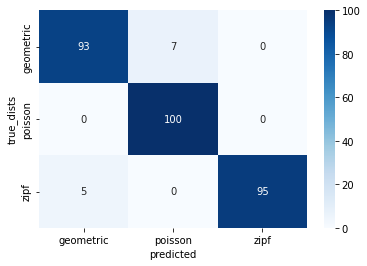

In [14]:
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.savefig(res_path / f"selection_results_{epsilon}.png", dpi=200)